# Imports

In [1]:
# Load config
from config import UNetTraining
from config import colors
config = UNetTraining.Configuration()
colors = colors.bcolors()

# 1.1 Data Collection

1.1 Data Collection
Label Areas:


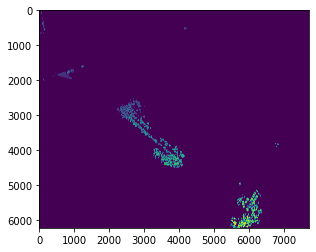

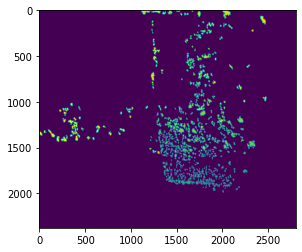

<AxesSubplot:>

In [2]:
import rasterio
from rasterio.plot import show
# get label area with export
src_label_nw = rasterio.open(config.filepath_label_nw)
src_label_se = rasterio.open(config.filepath_label_se)
src_label_read_nw = src_label_nw.read()
src_label_read_se = src_label_se.read()
print("1.1 Data Collection")
print("Label Areas:")
show(src_label_read_nw)
show(src_label_read_se)

In [3]:
filepath_labeled_areas = [config.filepath_label_nw, config.filepath_label_se]

# 1.2 Patch Generation

In [4]:
print("1.2 Patch Generation")

1.2 Patch Generation


## Create Label Area Patches

In [5]:
label_area_1 = rasterio.open(filepath_labeled_areas[0])
label_area_2 = rasterio.open(filepath_labeled_areas[1])
opened_label_areas = [label_area_1, label_area_2]

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify

satellite_img = rasterio.open(config.filepath_satellite)
# label_img = rasterio.open(config.filepath_label) # whole labeled image could 
# not be uploaded to the server because of its size of more than 45 GB

In [7]:
# label_area may be referred to as mask
patches_labels = []
for label_area in opened_label_areas:
    patches_labels = patchify(label_area.read(1), 
        (config.patch_size[0], config.patch_size[1]), 
        step=config.patch_size[0]-config.overlap)
print("Mask/Label Patch Shape:", patches_labels.shape)

Mask/Label Patch Shape: (10, 12, 256, 256)


Single Patch:


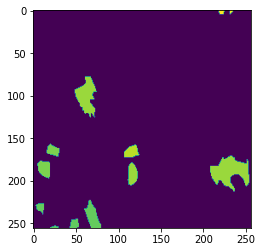

<AxesSubplot:>

In [8]:
# visualize single patch
# show(patches_labels[17][16])
print("Single Patch:")
show(patches_labels[7][9])

## Create Satellite Area Patches

In [9]:
from rasterio.windows import from_bounds
patches_satellite = []
for index, label_area in enumerate(opened_label_areas):
    # get coordinates
    cur_coords = (west, south, east, north) = opened_label_areas[index].bounds    
    satellite_area = satellite_img.read([1,2,3], window = from_bounds(west, south, east, north, satellite_img.transform))
    filename = opened_label_areas[0].name.replace(config.path_labeled_data_areas,"")[6:-4] # -4 to cut off the .tif file extension and 6 to cut off label
    filepath_satellite_area = "{}areas/{}.tif".format(config.path_patches_satellite, filename)

    patches_satellite = patchify(satellite_area, 
        (3, config.patch_size[0], config.patch_size[1]), 
        step=config.patch_size[0]-config.overlap)[0]
print("Satellite Patch Shape:", patches_satellite.shape)

Satellite Patch Shape: (10, 12, 3, 256, 256)


In [10]:
satellite_area_reshaped = np.reshape(satellite_area, (satellite_area.shape[1],satellite_area.shape[2],3))
# print("Reshaped Satellite Area:", satellite_area_reshaped.shape)

# 1.3 Data Preparation for Training

In [11]:
print("1.3 Data Preparation for Training")

1.3 Data Preparation for Training


## 1.3.1 Reshape Patches to Fit to the Model

In [12]:
print("Shape of Label and Satellite Patches:", patches_labels.shape, patches_satellite.shape)

Shape of Label and Satellite Patches: (10, 12, 256, 256) (10, 12, 3, 256, 256)


In [13]:
shape = patches_satellite.shape
patches_satellite_reshaped = patches_satellite.reshape(shape[0]*shape[1], shape[2], shape[3], shape[4])
print("Shape of Reshaped Satellite Patches:", patches_satellite_reshaped.shape)

Shape of Reshaped Satellite Patches: (120, 3, 256, 256)


In [14]:
shape = patches_labels.shape
patches_labels_reshaped = patches_labels.reshape(shape[0]*shape[1], shape[2], shape[3])
print("Shape of Reshaped Label Patches:", patches_labels_reshaped.shape)

Shape of Reshaped Label Patches: (120, 256, 256)


## 1.3.2 Feature Scaling & Data Correction

In [15]:
# scale the color values
patches_satellite_training = np.where(True, patches_satellite_reshaped / 255, patches_satellite_reshaped)

In [16]:
# Make all values of the array which are not 0, 1. Either label or no label. 
# This has to be performed, because the exported labels have color values, which have to be normalized. 
# Somehow, some color values have been above 255, which might have happened due to a faulty export from QGIS. 
patches_labels_training = np.where(patches_labels_reshaped != 0.0, 1.0, patches_labels_reshaped)
# conversion to the same type as patches_satellite_training ('float64')
patches_labels_training = patches_labels_training.astype(patches_satellite_training.dtype)

#### Create Training and Test Dataset

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(patches_satellite_training, patches_labels_training, test_size=config.test_ratio, random_state=42)

Sanity Check of a Single Patch:


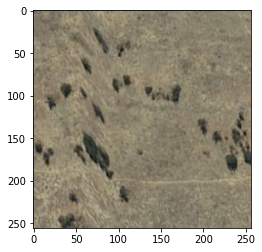

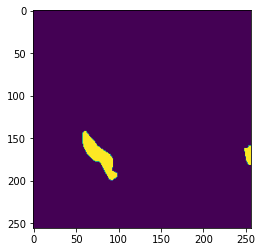

<AxesSubplot:>

In [18]:
# sanity check: check if satellite and label data matches
x = 16
print("Sanity Check of a Single Patch:")
show(X_train[x])
show(y_train[x])

In [21]:
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[3], X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[3], X_test.shape[1])

#### Convert to Tensor

In [32]:
import tensorflow as tf
X_train_tensor = tf.convert_to_tensor(X_train_reshaped, dtype=tf.float64)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float64)
X_test_tensor = tf.convert_to_tensor(X_test_reshaped, dtype=tf.float64)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float64)